## Plots for experiments in population setting

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from matplotlib import gridspec
from src import utils
import pickle

In [3]:
# Set tex font
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)

# For legend size
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')

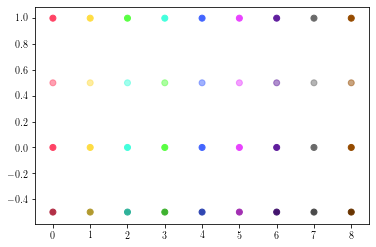

In [58]:
# Colors

def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

cmap = matplotlib.cm.get_cmap('tab20')
base = base = ["#ff4365", "#ffdd43", "#59ff43", "#43ffdd", "#4365ff", "#e943ff", "#601e9e", "#6a6a6a", "#964b00"]
plt.scatter(np.arange(len(base)), np.ones(len(base)), c = base)
base = [base[i] for i in [0,1,3,2,4,5,6,7,8]]
colors = to_rgb(base)
colorsa = to_rgb(base, a=0.5)
colorsb = to_rgb(base, b=0.7)
plt.scatter(np.arange(len(colors)), np.zeros(len(colors)), c = colors)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*0.5, c = colorsa)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*-0.5, c = colorsb)

### Load and process data

In [59]:
def load_experiments(filename):
    f = open(filename, "rb")
    results = pickle.load(f)
    return results[0], results[1::]

def merge_runs(old, new, min_merge=False):
    if len(old) == len(new) or (len(old) < len(new) and min_merge):
        for i in range(len(old)):
            old[i] += new[i]
    else:
        raise Exception("Cannot merge")
    return old

In [60]:
filenames = [
    "experiments/results_1589124724_runs:8_max_iter:-1_random_state:0_tag:may9pop_G:500_k:3.0_p_min:15_p_max:15_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_do:False_i_mean:10_i_var:1_finite:False.pickle",
    "experiments/results_1589130144_runs:8_max_iter:-1_random_state:1_tag:may9pop_G:500_k:3.0_p_min:15_p_max:15_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_do:False_i_mean:10_i_var:1_finite:False.pickle"
]
    
cases, results = load_experiments(filenames[0])
for filename in filenames[1::]:
        print("Loading %s" % filename)
        new_cases, new_results = load_experiments(filename)
        cases += new_cases
        for k in range(len(results)):
            results[k] = merge_runs(results[k], new_results[k])
max_iter = 15
print("\nLoaded a total of %d graphs with %d runs each" % (len(results[0][0]), len(results[0])))

Loading experiments/results_1589130144_runs:8_max_iter:-1_random_state:1_tag:may9pop_G:500_k:3.0_p_min:15_p_max:15_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_do:False_i_mean:10_i_var:1_finite:False.pickle

Loaded a total of 1000 graphs with 8 runs each


In [61]:
def jaccard_sim(A,B):
    A = set(A) if type(A) is not set else A
    B = set(B) if type(B) is not set else B
    return len(A & B) / len(A | B)

In [62]:
runs = len(results[0])
N = len(results[0][0])
P = len(results)

no_ints = np.zeros((len(results), runs, N))
all_trajectories_jac = {}
names = []
for k, policy_runs in enumerate(results):
    name = policy_runs[0][0].policy
    names.append(name)
    trajectories_jac = []
    for i,run_results in enumerate(policy_runs):
        for j, result in enumerate(run_results):
            # add final result to history of estimates
            estimates = result.estimates() + [result.estimate]
            try:
                # checks whether truth is contained in estimates and retrieves index
                no_ints[k, i, j] = estimates.index(cases[j].truth)
            except ValueError:
                # if not, add max. intervention number
                no_ints[k, i, j] = len(result.interventions())
            trajectory_jac = list(map(lambda estimate: jaccard_sim(cases[j].truth, estimate), estimates))
            trajectories_jac.append(trajectory_jac)
    all_trajectories_jac[name] = trajectories_jac

**Summary of graphs used**

1000 graphs in total


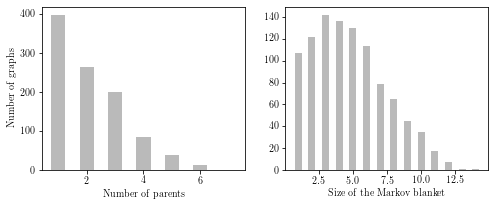

In [63]:
n_parents = np.zeros(N)
n_vars = np.zeros(N)
size_mb = np.zeros(N)
for i, case in enumerate(cases):
    n_parents[i] = len(case.truth)
    n_vars[i] = case.sem.p
    mb = utils.graph_info(case.target, case.sem.W)[3]
    size_mb[i] = len(mb)

def plot_hist(data, title):
    bins = np.arange(data.min(), data.max()+2)-0.5
    hist = plt.hist(data, bins, rwidth=0.5, align='mid', color="#BABABA")#colorsb[2])
    plt.xlabel(title)
    
plt.figure(figsize=(8,3))
#plt.subplot(131), plot_hist(n_vars, "Number of variables")
plt.subplot(121), plot_hist(n_parents, "Number of parents"), plt.ylabel("Number of graphs")
plt.subplot(122), plot_hist(size_mb, "Size of the Markov blanket")
print("%d graphs in total" % N)

### PLOT A: Average jaccard similarity + avg. number of interventions

In [76]:
# NOTE!: Both graphs and mask variables are used! Both must be appropriately set
graphs, mask = [], []
for i, case in enumerate(cases):
    parents, children, poc, mb = utils.graph_info(case.target, case.sem.W)
    if len(parents) < len(mb):
        graphs.append(i)
        mask = np.hstack([mask, np.arange(0, N*runs, N) + i])
mask = mask.astype(int)

# To select all graphs, uncomment next line
#graphs, mask = list(range(N)), list(range(N*runs))

# Check selection
print(len(graphs), "graphs selected = ", len(mask), "experiments")

595 graphs selected =  4760 experiments


In [79]:
def violin_plot(NoInts, ax, parents = None):
    # Plotting
    means = NoInts.mean(axis=1)
    no_parents = np.array(list(map(lambda case: len(case.truth), cases)))
    parents = range(no_parents.min(), no_parents.max() + 1) if parents is None else parents
    for p in parents:
        idx = np.where(no_parents == p)[0]
        # Plot lines first
        for i in idx:            
            plt.plot(xaxis[i,:], means[:, i].T, color=ecolor, zorder=0, linewidth=0.5, alpha=0.2)
        # Plot dots
        for i in idx:
            plt.scatter(xaxis[i,:],
                        means[:, i].T,
                        marker='.',#markers[p-1],
                        c=colors[0:P],
                        zorder=1,
                        edgecolors=colorsb, 
                        alpha=0.6)
    
    parts = ax.violinplot([means[i,:] for i in range(means.shape[0])], 
                  positions=np.arange(P), showmeans=True)
    parts['cbars'].set_edgecolor(violin_color)
    parts['cmeans'].set_edgecolor(violin_color)
    parts['cmaxes'].set_edgecolor(violin_color)
    parts['cmins'].set_edgecolor(violin_color)    
    for pc in parts['bodies']:
        pc.set_facecolor(violin_color)
        pc.set_edgecolor(violin_color)
        pc.set_alpha(.5)
    # Set labels 
    plt.ylabel("Avg. no. of interventions")
    ax.set_xticks([0,1,2])
    total_averages = means.mean(axis=1)
    labels = []
    for i, avg in enumerate(total_averages):
        labels.append(names[i] + "\n(%0.2f)" % avg)
    ax.set_xticklabels(labels, ha="center", rotation=0)

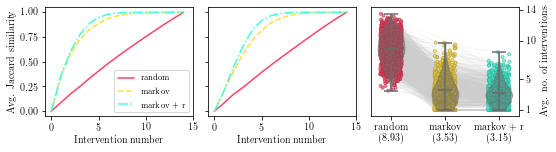

In [80]:
# Together
gs = gridspec.GridSpec(1, 3, wspace=0.1, hspace=0.35)
plt.figure(figsize=(8.5,2))

markers = ["o", "s", "^"]
linestyle = ["-", "--", "-."]

# PLOT A
plt.subplot(gs[0])
ax = plt.gca()
for i, (name, trajectories) in enumerate(all_trajectories_jac.items()):
    trajectories = np.array(trajectories)
    plt.plot(trajectories.mean(axis=0)[0:15], linewidth=1.5, color=colors[i], label=name, linestyle=linestyle[i])
plt.xlabel("Intervention number")
plt.ylabel("Avg. Jaccard similarity")
ax.set_xticks(range(0, trajectories.shape[1], 5))
plt.legend(prop=fontP)

# PLOT B
plt.subplot(gs[1])
ax = plt.gca()
for i, (name, trajectories) in enumerate(all_trajectories_jac.items()):
    trajectories = np.array(trajectories)[mask,:]
    plt.plot(trajectories.mean(axis=0)[0:15], linewidth=1.5, color=colors[i], label=name, linestyle=linestyle[i])
    #plt.plot(trajectories[mask,:].mean(axis=0)[0:15], linewidth=1.5, color=colors[i], label=name, linestyle=':')
plt.xlabel("Intervention number")
#plt.ylabel("Avg. Jaccard similarity")
ax.set_xticks(range(0, trajectories.shape[1], 5))
ax.set_yticklabels([])
#plt.legend(prop=fontP)

# PLOT C
plt.subplot(gs[2])
ax = plt.gca()
dev = 0.2
xaxis = np.tile(np.arange(P), (N, 1)) - np.outer(np.linspace(-dev, dev, N), np.ones(P))
ecolor = "#cdcdcd"
violin_color = colors[7]#'lightseagreen'
markers = [".", "$2$", "^", "s", "p", "H", "$7$"]

violin_plot(no_ints[:,:,:], ax)
ax.set_yticks([1,5,10,14])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

plt.savefig('figures/population_together.pdf', bbox_inches='tight')

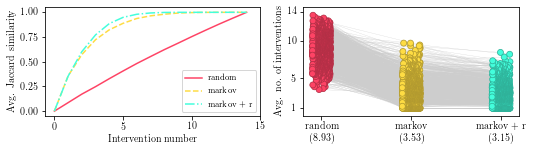

In [49]:
# Together
gs = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.35)
plt.figure(figsize=(8.5,2))

markers = ["o", "s", "^"]
linestyle = ["-", "--", "-."]

# PLOT A
plt.subplot(gs[0])
ax = plt.gca()
for i, (name, trajectories) in enumerate(all_trajectories_jac.items()):
    trajectories = np.array(trajectories)
    plt.plot(trajectories.mean(axis=0)[0:15], linewidth=1.5, color=colors[i], label=name, linestyle=linestyle[i])#marker=markers[i])
plt.xlabel("Intervention number")
plt.ylabel("Avg. Jaccard similarity")
ax.set_xticks(range(0, trajectories.shape[1], 5))
plt.legend(prop=fontP)

# PLOT B
plt.subplot(gs[1])
ax = plt.gca()
idx = range(N)
Ns = len(idx)
means = no_ints.mean(axis=1)
dev = 0.1
xaxis = np.tile([0,1,2], (Ns, 1)) - np.outer(np.linspace(-dev, dev, Ns), [1,1,1])
ecolor = "#cdcdcd"
for i in range(Ns):
    plt.plot(xaxis[i,:], means[:, i].T, color=ecolor, zorder=0, LineWidth=0.25)
for i in range(Ns):
    plt.scatter(xaxis[i,:], means[:, i].T, c=colors[[0,1,2]], marker="o", zorder=1, edgecolors=colorsb[[0,1,2]], linewidths=0.75)
ax = plt.gca()
ax.set_xticks([0,1,2])
plt.xlim([-0.2, 2.2])
plt.ylabel("Avg. no. of interventions")
plt.savefig('figures/int_numbers_population.pdf', bbox_inches='tight')
total_averages = means.mean(axis=1)
labels = []
for i,name in enumerate(names):
    labels.append(name + "\n(%0.2f)" % total_averages[i])
ax.set_xticklabels(labels, ha="center", rotation=0)
ax.set_yticks([1, 5, 10, 14])

plt.savefig('figures/population_together_2.pdf', bbox_inches='tight')

### Plot C: Distribution of number of interventions required

In [ ]:
#idx, = np.where(no_ints[2,:,:].mean(axis=0) > 1)
idx = [9,2,3,4,6,7,1,10,11,13,14,15]#list(range(16))
Ns = len(idx)
all_data = np.zeros((runs,Ns*3))
all_data[:, 0:Ns*3:3] = no_ints[2,:,idx].T
all_data[:, 1:Ns*3:3] = no_ints[0,:,idx].T
all_data[:, 2:Ns*3:3] = no_ints[1,:,idx].T
labels = (np.floor(np.arange(0,Ns*3) / 3) + 1).astype(int)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 3))
bplot = axes.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,
                     medianprops = {'color': 'black'},
                     labels = labels)
for i,patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colors[i%3])
axes.set_xticks([])
plt.ylabel("Number of interventions")
plt.legend(bplot['boxes'][0:3], ['random', 'markov', 'markov + e + r'], loc=8, prop=fontP, ncol=3, bbox_to_anchor=[0.5,-0.15]);
for i in range(Ns):
    x = i*3+0.5
    plt.plot([x,x], [0.75,max_iter-0.75], c='#000000', LineWidth=1)
plt.ylim(0.5,max_iter-0.5)
plt.savefig("figures/intervention_distributions_population.pdf", bbox_inches='tight')